# 作業 : (Kaggle)鐵達尼生存預測

# [作業目標]
- 試著模仿範例寫法, 在鐵達尼生存預測中, 使用葉編碼並觀察預測效果

# [作業重點]
- 仿造範例, 完成葉編碼的寫作 : 使用隨機森林 (In[3], Out[3], In[4], Out[4])
- 仿造範例, 觀察葉編碼搭配邏輯斯迴歸後的效果 (In[5], Out[5], In[6], Out[6]) 

In [1]:
# 做完特徵工程前的所有準備
import pandas as pd
import numpy as np
import copy
import warnings; warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# 因為擬合(fit)與編碼(transform)需要分開, 因此不使用.get_dummy, 而採用 sklearn 的 OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

dataset = pd.read_csv('C:/Users/rich chang/Documents/GitHub/3rd-ML100Days/data/titanic_train.csv')
Y = dataset['Survived']
X = dataset.drop(['PassengerId', 'Survived'] , axis=1)
X.head()


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
# 因為需要把類別型與數值型特徵都加入, 故使用最簡版的特徵工程
LEncoder = LabelEncoder()
MMEncoder = MinMaxScaler()
for i in X.columns:
    X[i] = X[i].fillna(-1)
    if X[i].dtype == 'object':
        X[i] = LEncoder.fit_transform(list(X[i].values))
    X[i] = MMEncoder.fit_transform(X[i].values.reshape(-1, 1))
X.head()


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1.0,0.121348,1.0,0.283951,0.125,0.0,0.769118,0.014151,0.000000,1.000000
1,0.0,0.213483,0.0,0.481481,0.125,0.0,0.876471,0.139136,0.557823,0.333333
2,1.0,0.396629,0.0,0.333333,0.000,0.0,0.983824,0.015469,0.000000,1.000000
3,0.0,0.305618,0.0,0.444444,0.125,0.0,0.072059,0.103644,0.380952,1.000000
4,1.0,0.016854,1.0,0.444444,0.000,0.0,0.694118,0.015713,0.000000,1.000000


In [3]:
X = X.values
# 因為訓練邏輯斯迴歸時也要資料, 因此將訓練及切成三部分 train / val / test, 採用 test 驗證而非 k-fold 交叉驗證
# train 用來訓練梯度提升樹, val 用來訓練邏輯斯迴歸, test 驗證效果
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.5)


# 作業1
* 請對照範例，完成隨機森林的鐵達尼生存率預測，以及對應的葉編碼+邏輯斯迴歸

In [4]:
# 隨機森林擬合後, 再將葉編碼 (*.apply) 結果做獨熱 / 邏輯斯迴歸
# 隨機森林的葉編碼(.apply)不需要加上[:, :, 0], 直接用rf.apply()調用即可, 本作業其餘寫法相同
rf = RandomForestClassifier(n_estimators=20, min_samples_split=10, min_samples_leaf=5, 
                            max_features=4, max_depth=3, bootstrap=True)
onehot = OneHotEncoder()
lr = LogisticRegression(solver='lbfgs', max_iter=1000)

rf.fit(X_train, Y_train)
onehot.fit(rf.apply(X_train))
lr.fit(onehot.transform(rf.apply(X_val)), Y_val)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [5]:
# 將隨機森林+葉編碼+邏輯斯迴歸結果輸出
pred_rf_lr = lr.predict_proba(onehot.transform(rf.apply(X_test)))[:, 1]
fpr_rf_lr, tpr_rf_lr, _ = roc_curve(Y_test, pred_rf_lr)

# 將隨機森林結果輸出
pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(Y_test, pred_rf)
print(fpr_rf, '\n')
print(tpr_rf, '\n')
print(_, '\n')


[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.00381679 0.00381679 0.00763359 0.00763359
 0.00763359 0.00763359 0.00763359 0.00763359 0.01145038 0.01145038
 0.01145038 0.01145038 0.01145038 0.01145038 0.01145038 0.01145038
 0.01526718 0.01526718 0.02290076 0.03053435 0.03435115 0.03435115
 0.03435115 0.03435115 0.03816794 0.03816794 0.04198473 0.04198473
 0.04580153 0.04580153 0.04961832 0.04961832 0.04961832 0.04961832
 0.05343511 0.05343511 0.05343511 0.0610687  0.0610687  0.06870229
 0.06870229 0.08015267 0.08015267 0.08778626 0.08778626 0.09541985
 0.09541985 0.10305344 0.10305344 0.10687023 0.10687023 0.11832061
 0.12977099 0.12977099 0.14503817 0.15648855 0.15648855 0.16793893
 0.16793893 0.17557252 0.17557252 0.17938931 0.19083969 0.19083969
 0.19465649 0.19465649 0.21374046 0.21374046 0.21755725 0.21755725
 0.22900763 0.22900763 0.24427481 0.24427481 0.2480916  0.25572519
 0.25954198

# 作業2
* 上述的結果，葉編碼是否有提高預測的正確性呢?

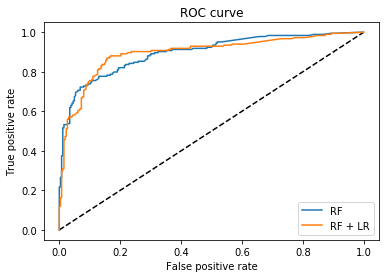

In [6]:
# 將結果繪圖
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lr, tpr_rf_lr, label='RF + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
